<a href="https://colab.research.google.com/github/Ketan-Karande/MSc_AI_Thesis/blob/main/KetanKarande_R00195928_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
!pip install lime
import cv2
import glob
import os
import lime
import random
import matplotlib
import keras
from keras.models import Model
import xgboost as xgb
import numpy as np
import pandas as pd
from lime import lime_image
import skimage.io as io
import skimage.transform as trans
import keras.backend as K
from skimage.io import imshow
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from skimage.segmentation import mark_boundaries
from keras.layers import Conv2D,PReLU,Conv2DTranspose,add,concatenate,Input,Dropout,BatchNormalization,Activation, Lambda, Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# WORK PACKAGE 1: Task 1: Predicting patient severity score 

In [ ]:
seed(10)
set_seed(20)
drive.mount('/content/gdrive', force_remount=True)

#Getting data from multiple sources
def get_data(url, image_path, severity_url):
  data_all_patient = pd.read_csv(url)
  covid_patients = data_all_patient ['finding'] == 'Pneumonia/Viral/COVID-19'
  covid_patients_rows = np.where(covid_patients)
  data_meta = data_all_patient [data_all_patient ['finding'] == 'Pneumonia/Viral/COVID-19']

  data_image = []
  data_sev_score = pd.read_csv(severity_url, skiprows=4, header = 1)  #Skipping first 4 rows and setting 5th row as header

  for img in os.listdir(image_path):  #To get list of all image names--img is image name
      image_array = cv2.imread (os.path.join(image_path,img))  # os.path.join(image_path,img) Gives image path
      new_array = cv2.resize(image_array, (200, 200))
      
      idx = data_sev_score.index[data_sev_score['filename'] == img] #Getting index from severity csv file using image name
      idx_meta = data_meta.index[data_meta['filename'] == img] #Getting index from metadata csv file using image name
      if idx.size != 0:  #idx.size == 0 means empty array with .size = 0 which represents image name found in 'images' folder is not present in severity csv data
          geo_value = data_sev_score ['geographic_mean'][idx] #Using index to find geo_mean of the image
          opacity_value = data_sev_score ['opacity_mean'][idx]  #Using index to find opacity_mean of the image
          data_image.append([new_array, geo_value, opacity_value, idx, idx_meta, img])
    
  return data_meta, data_image

def split_data(X, y):
  return train_test_split(X, y, test_size = 0.2, random_state = 4)

def get_train_test(data_image, geo = True):    
  X =[]
  y =[]
  common_idxs = []
  for images, geo_values, opa_values, idx_sev, idx_metadata, imgg in data_image:  # Here idx is idx_sev and idx_meta is idx_metadata
    if geo:
      y.append(geo_values) 
    else:
      y.append(opa_values) 

    X.append(images)
    common_idxs.append(idx_metadata) 

  X = np.array(X).reshape(-1, 200, 200, 3)
  y = np.array(y)
  #Normalizing images
  X = X.astype('float32')
  X /= 255
  X_train, X_test, y_train, y_test = split_data(X, y)

  return X_train, X_test, y_train, y_test, common_idxs, X

#Fitting CNN model with Data augmentation -- Severity score data and images folder
def model_wp1_cnn(X_train, X_test, y_train, y_test):

  IMAGE_SIZE = 200
  NUMBER_FILTERS=64      #Number of filters for baseline
  KERNEL_SIZE=(3,3)      #Filter size
  INPUT_SHAPE=(IMAGE_SIZE,IMAGE_SIZE,3)
  POOL_SIZE=(2,2)        #Pool size
  FC_NEURONS_1=128       #Neurons in fully connected layer 1
  NUM_EPOCHS=10
  BATCH_SIZE=40
  

  model = Sequential([Conv2D(32, KERNEL_SIZE,padding="same", input_shape=INPUT_SHAPE, activation='relu'), #Convolutional layer 1
                      Conv2D(NUMBER_FILTERS, KERNEL_SIZE,padding="same", input_shape=INPUT_SHAPE, activation='relu'), #Convolutional layer 1
                      Conv2D(32, KERNEL_SIZE,padding="same", input_shape=INPUT_SHAPE, activation='relu'), 
                      Conv2D(64, KERNEL_SIZE,padding="same", input_shape=INPUT_SHAPE, activation='relu'),
                      Conv2D(32, KERNEL_SIZE,padding="same", input_shape=INPUT_SHAPE, activation='relu'),
                      MaxPooling2D(pool_size=POOL_SIZE),       #Pooling layer 1
                      Flatten(),                               #Flatten
                      Dense(FC_NEURONS_1, activation='relu'),  #Fully connected layer
                      Dense(1, kernel_initializer='normal'),
                      ])
  
  #Checkpointing
  fname = "Model " + ".hdf5"  #saving all weights to single file getting updated with best results seen
  checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_weights_only=True, save_best_only=True, verbose=0)  #Model with lowest val loss
  print ('Best filename ',fname)

  # Model compile
  model.compile('adam',loss='mean_absolute_error')  #loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError()]
  early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)  #Early stopping with patience 3

  # Data Generation
  idg_args = dict(shear_range=0.3, 
                  zoom_range=0.3, 
                  rotation_range=50, 
                  horizontal_flip=True,
                  width_shift_range = 0.1) 

  generate_train_data = ImageDataGenerator(**idg_args) #unpacking Image data generator class params
  generate_train = generate_train_data.flow(X_train, y_train, batch_size=BATCH_SIZE)

  #Model fitting
  h = model.fit(generate_train, 
                validation_data=(X_test, y_test), 
                steps_per_epoch=len(X_train)/ BATCH_SIZE, 
                epochs = NUM_EPOCHS,
                callbacks=[checkpoint,early_stop])

  #Get weights and prediction from check point file with minimum val loss
  model.load_weights(fname)

  return model

#Merging severity score data with metadata score
def get_merged_data(data_meta_new, data_image, predictions_X, common_idxs, geo = True):
  data_img_dict = {'filename':[]}
  opacity = []
  geographic = []

  for idx_data_image, value in enumerate(data_image):
    data_img_dict['filename'].append(value[5]) #value contains images, geo_values, opa_values, idx_sev, idx_metadata, imgg
    if geo:
      geographic.append(predictions_X.flatten()[idx_data_image]) #Data_image and X are in same order of row values
    else:
      opacity.append(predictions_X.flatten()[idx_data_image])
    
  if geo:
    data_img_dict['geographic_mean_pred'] = geographic
  else:
    data_img_dict['opacity_mean_pred'] = opacity

  data_img_df = pd.DataFrame(data_img_dict)

  #Data imputation in data_meta_new from data_image_df based on same filenames
  if geo:
    data_meta_new['geographic_mean_pred'] = data_meta_new['filename'].map(data_img_df.set_index('filename')['geographic_mean_pred']) 
  else:
    data_meta_new['opacity_mean_pred'] = data_meta_new['filename'].map(data_img_df.set_index('filename')['opacity_mean_pred']) 

  return data_meta_new

# Calculate Mean Absolute Error
def get_mae(y_test, predictions):
  mae = tf.keras.losses.MeanAbsoluteError()
  print('MAE is', mae(y_test, predictions).numpy())
  mae(y_test, predictions).numpy()

#Run functions
def get_sev_merge_metadata(url, image_path, severity_url, Geo, data = None):
  data_meta, data_image = get_data(url, image_path, severity_url)
  X_train, X_test, y_train, y_test, common_idxs, X = get_train_test(data_image, geo = Geo) #Geo means
  model = model_wp1_cnn(X_train, X_test, y_train, y_test)
  predictions=model.predict(X_test,batch_size = 40) #predicting geo
  get_mae(y_test, predictions)
  predictions_X=model.predict(X,batch_size = 40)  #Length of predictions_X is similar to data_image

  if Geo:
    #Finding all the indexes without matching filenames from sev score file and data_meta
    uncommon_idxs = []
    for i in range(0, len(data_meta)):
      if i not in common_idxs:
        uncommon_idxs.append(i)

    data_meta_new = data_meta.copy()  
    data_meta_new['geographic_mean_pred'] = ''
    data_meta_new['opacity_mean_pred'] = ''
    data_meta_new = data_meta_new.drop(data_meta_new.index[uncommon_idxs])  #Dropping all rows of metadata which don't have filenames from images folder
  else:
    data_meta_new = data

  data_meta_new = get_merged_data(data_meta_new, data_image, predictions_X, common_idxs, geo = Geo)

  return data_meta_new

#Cleaning MetaData
def get_encoded(data, categorical):
  enc = OrdinalEncoder()
  data[categorical] = enc.fit_transform(data[categorical])
  return data

def get_cleaned_data(data_meta_new):
  data_meta_cleaned = data_meta_new.drop(columns=['patientid', 'finding', 'extubated', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'modality', 'date', 'location', 'folder', 'filename', 
                    'doi', 'url', 'license', 'clinical_notes', 'other_notes', 'Unnamed: 29']) #Dropping non required columns
  data_meta_cleaned['went_icu'] = data_meta_cleaned['went_icu'].fillna('Unknown') #Replacing missing values with new category 'unknown'
  get_encoded(data_meta_cleaned, categorical) #Doing ordinal encoding on categorical variables

  return data_meta_cleaned

#Data Imputation for missing data
def get_imputed_data(data_meta_cleaned):
  lr = LinearRegression()
  imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=0, imputation_order='ascending',random_state=0) #Iterative imputation on missing values
  dc = imp.fit_transform(data_meta_cleaned)
  dc_df = pd.DataFrame(dc) 
  dc_df.columns = [data_meta_cleaned.columns] #Renaming columns in dataframe
  dc_df[categorical] = dc_df[categorical].round(0).astype(int) #Rounding all the categorical variable and changing data types
  dc_df[numerical] = dc_df[numerical].round(1) #Rounding all numerical variables upto 1 decimal

  return dc_df

# Data
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv"
image_path = "/content/gdrive/My Drive/AIThesis/images"
severity_url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/annotations/covid-severity-scores.csv"
numerical = ['offset', 'age', 'temperature', 'pO2_saturation', 'geographic_mean_pred', 'opacity_mean_pred']
categorical = ['sex', 'RT_PCR_positive', 'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'view'] 

#Implementation Work package 1 --- Image processing, Data augmentation, Merge sev score data with metadata
data_meta_new = get_sev_merge_metadata(url, image_path, severity_url, Geo = True) #Get predictions for Geographic means and merge with metadata
data_meta_new = get_sev_merge_metadata(url, image_path, severity_url, Geo = False, data = data_meta_new) #Get predictions for Opacity means and merge with metadata
data_meta_cleaned = get_cleaned_data(data_meta_new)
data_meta_imputed = get_imputed_data(data_meta_cleaned)
data_meta_imputed.head(20)


Mounted at /content/gdrive
Best filename  Model .hdf5
Epoch 1/10
1/1 [==============================] - 45s 23s/step - loss: 4.4197 - val_loss: 3.8846
Epoch 2/10
1/1 [==============================] - 40s 26s/step - loss: 3.4606 - val_loss: 1.5574
Epoch 3/10
1/1 [==============================] - 39s 25s/step - loss: 1.9683 - val_loss: 2.0908
Epoch 4/10
1/1 [==============================] - 38s 22s/step - loss: 2.0022 - val_loss: 2.3355
Epoch 5/10
1/1 [==============================] - 39s 22s/step - loss: 2.5356 - val_loss: 1.8510
Epoch 6/10
1/1 [==============================] - 39s 25s/step - loss: 2.2097 - val_loss: 1.7367
Epoch 7/10
1/1 [==============================] - 39s 22s/step - loss: 2.1382 - val_loss: 1.4978
Epoch 8/10
1/1 [==============================] - 38s 21s/step - loss: 1.9622 - val_loss: 1.6152
Epoch 9/10
1/1 [==============================] - 38s 25s/step - loss: 2.0298 - val_loss: 1.5354
Epoch 10/10
1/1 [==============================] - 38s 25s/step - loss: 1

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


,offset,sex,age,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,temperature,pO2_saturation,view,geographic_mean_pred,opacity_mean_pred
0,0.0,1,65.0,1,1,0,0,0,0,1,37.9,125.7,5,3.5,3.0
1,3.0,1,65.0,1,1,0,0,0,0,1,38.0,122.2,5,3.9,3.3
2,5.0,1,65.0,1,1,0,0,0,0,1,38.0,120.4,5,3.7,3.2
3,6.0,1,65.0,1,1,0,0,0,0,1,38.0,119.7,5,3.5,3.0
4,0.0,0,52.0,1,1,0,0,0,0,0,39.2,87.3,5,2.6,2.3
5,5.0,0,52.0,1,1,0,0,0,0,0,39.1,84.5,5,2.7,2.4
6,4.0,1,63.4,1,1,1,1,2,1,6,39.9,51.4,5,2.8,2.5
7,0.0,1,56.0,1,1,1,0,1,0,0,38.6,97.0,5,2.6,2.4
8,7.0,1,61.9,1,1,0,0,1,0,2,38.8,89.5,5,3.8,3.3
9,5.0,0,59.0,0,1,1,0,1,0,4,38.8,76.2,5,2.8,2.6


# WORK PACKAGE 1: Task 2: Predicting if patients needs to be hospitalized

In [ ]:
#Grid Search with Repeated Stratified K fold
def do_gridsearch(model, param_grid, X_train, y_train, model_name):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
  result = grid_search.fit(X_train, y_train)
  best_params = result.best_params_
  print('\n\nModel: {}, Best Accuracy: {}% using Hyper parameters like {}\n'.format(model_name, round((result.best_score_)*100,2), result.best_params_))
  
  return best_params, result

#Random forest classifier Model fitting 
def model_wp1_rf(X_train, X_test, y_train, y_test):
  model = RandomForestClassifier()
  param_grid = {
      'bootstrap': [True],
      'max_depth': [40, 50, 60],
      'max_features': [4, 5], 
      'min_samples_leaf': [1, 2],
      'min_samples_split': [3, 5],
      'n_estimators': [50, 100]
  }
  best_params, result = do_gridsearch(model, param_grid, X_train, y_train, 'RandomForestClassifier')
 
  model = RandomForestClassifier(**best_params)
  model.fit(X_train, y_train)
  predictions_rf = model.predict(X_test)

  return result

#XGBoost classifier Model fitting 
def model_wp1_xgb(X_train, X_test, y_train, y_test):
  #obtaining default parameters by calling .fit() to XGBoost model instance
  model = xgb.XGBClassifier()
  param_grid= {
              'objective' : ['binary:logistic'],
              'booster' : ['gbtree'],
              'eval_metric' : ['auc'],
              'tree_method' : ['hist'],
              'grow_policy' : ['lossguide'],
              'use_label_encoder' : [False],
              'learning_rate' : [0.05,0.10,0.15,0.20],
              'max_depth' : [ 3, 4, 5, 6, 8],
              'min_child_weight' : [ 1, 3, 5, 7 ],
              'gamma': [ 0.0, 0.1, 0.2 , 0.3],
              'colsample_bytree' : [ 0.3, 0.4, 0.5]
              }

  best_params, result = do_gridsearch(model, param_grid, X_train, y_train, 'XGBoostClassifier')

  # best_params = result.best_params_
  model = xgb.XGBClassifier(**best_params)
  model.fit(X_train, y_train)
  predictions_xgb = model.predict(X_test)

  return result

#Random forest classifier to predict patients who need to be hospitalized
X = data_meta_imputed.drop('went_icu', axis=1) #Include all variables except went_icu
y = data_meta_imputed[['went_icu']] #Only variable is went_icu
X_train, X_test, y_train, y_test = split_data(X, y)

#Random Forest and XGBoost model fitting
result_rf = model_wp1_rf(X_train, X_test, y_train, y_test)
result_xgb = model_wp1_xgb(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/loc



Model: RandomForestClassifier, Best Accuracy: 89.21% using Hyper parameters like {'bootstrap': True, 'max_depth': 50, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




Model: XGBoostClassifier, Best Accuracy: 92.35% using Hyper parameters like {'booster': 'gbtree', 'colsample_bytree': 0.4, 'eval_metric': 'auc', 'gamma': 0.0, 'grow_policy': 'lossguide', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'objective': 'binary:logistic', 'tree_method': 'hist', 'use_label_encoder': False}



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# WORK PACKAGE 2: Task 1: Lesion Quantification with V-Net model
# Load Kaggle Data - X, y


In [ ]:
# Get kaggle data
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":<USERNAME>,"key":<KEY>}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

# !kaggle datasets list 
!kaggle datasets download -d anasmohammedtahir/covidqu  #Download covidqu dataset
!unzip covidqu.zip

def extract_images():
  img_train = [cv2.imread(file, cv2.IMREAD_COLOR) for file in glob.glob("/content/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/*.png")]
  img_train_infmask = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob("/content/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks/*.png")]
  img_train_lungmask = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob("/content/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/lung masks/*.png")]

  return img_train, img_train_infmask, img_train_lungmask

def get_transformed_images(image_folder, mask = False):
  new_folder = []
  for x in image_folder:
    x = cv2.resize(x, (W,H))
    x = x/255.0
    if mask:
      x = x > 0.5
    x = x.astype(np.float32)
    if mask:
      x = np.expand_dims(x, axis = -1)
    new_folder.append(x)

  return np.array(new_folder)

W, H = 256, 256
img_train, img_train_infmask, img_train_lungmask = extract_images()
X = get_transformed_images(img_train)
y = get_transformed_images(img_train_infmask, mask = True)

X[1].shape, y[1].shape

((256, 256, 3), (256, 256, 1))

# Run V-net model

In [ ]:
tf.random.set_seed(1234)

#Creating validation metrics to be used by V-net model
def dice_coef(y_true, y_pred, smooth, thresh):
    y_true_f =y_true
    y_pred_f =y_pred
    intersection = K.sum(y_true_f * y_pred_f,axis=(0,1,2))
    denom =K.sum(y_true_f,axis=(0,1,2)) + K.sum(y_pred_f,axis=(0,1,2))
    return K.mean((2. * intersection + smooth) /(denom + smooth))

def dice_loss(smooth, thresh):
    def dice(y_true, y_pred):
        return 1-dice_coef(y_true, y_pred, smooth, thresh)
    return dice
 
#Creating compression block of V-net model 
def resBlock(conv,stage,keep_prob,stage_num=5):
    
    inputs=conv
    
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([inputs,conv]))
    conv_drop=Dropout(keep_prob)(conv_add)
    
    if stage<stage_num:
        conv_downsample=PReLU()(BatchNormalization()(Conv2D(16*(2**stage), 2, strides=(2, 2),activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv_drop)))
        return conv_downsample,conv_add
    else:
        return conv_add,conv_add

#Creating de-compression block of V-net model         
def up_resBlock(forward_conv,input_conv,stage):
    
    conv=concatenate([forward_conv,input_conv],axis = -1)
    print('conv_concatenate:',conv.get_shape().as_list())
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
        print('conv_up_stage_%d:' %stage,conv.get_shape().as_list())
    conv_add=PReLU()(add([input_conv,conv]))
    if stage>1:
        conv_upsample=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(stage-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

#V-net model
def vnet(pretrained_weights = None,input_size = (256,256,3),num_class=1,is_training=True,stage_num=5,thresh=0.5):
    keep_prob = 0.1 
    features=[]
    input_model = Input(input_size)
    x=PReLU()(BatchNormalization()(Conv2D(16, 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(input_model)))
    
    for s in range(1,stage_num+1):
        x,feature=resBlock(x,s,keep_prob,stage_num)
        features.append(feature)
        
    conv_up=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(s-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(x)))
    
    for d in range(stage_num-1,0,-1):
        conv_up=up_resBlock(features[d-1],conv_up,d)
    if num_class>1:
        conv_out=Conv2D(num_class, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    else:
        conv_out=Conv2D(num_class, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    
    
    model=Model(inputs=input_model,outputs=conv_out)
    print(model.output_shape)
    
     #Checkpointing
    fname = "Model 1" + ".hdf5"  #saving all weights to single file getting updated with best results seen
    checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_weights_only=True, save_best_only=True, verbose=0)  #Model with lowest val loss
    print ('Best filename ',fname)

    model_dice=dice_loss(smooth=1e-5,thresh=0.5)
    model.compile(optimizer = 'adam', loss = model_dice, metrics = ['accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model

#Get predicted image segments
def get_pred_img(model, image, mask):
  #Original Image
  img_cpy = image.copy() 
  img_cpy = np.expand_dims(img_cpy, axis = 0)
  #Predicted Mask
  pred = model.predict(img_cpy)>0.5 
  pred = pred.astype(np.int32)
  pred = np.concatenate([pred, pred, pred], axis = -1) #converting single channel to 3 channels
  pred = np.squeeze(pred*255) #Converting pixels back to 0, 255
  #Original Mask
  mask = np.concatenate([mask, mask, mask], axis = -1) 
  #Seperator line between images
  sep_line = np.ones((H, 10, 3))*255   
  #Showing all images
  img = np.concatenate([image, sep_line, mask, sep_line, pred], axis = 1) 
  plt.title('Original Image - Original Mask - Predicted Mask')
  plt.imshow(img)
  plt.show()

  return pred

#Saving model weights in Google Drive  
def save_model(model):
  drive.mount('/content/gdrive', force_remount=True)

  model_json = model.to_json()
  with open ("model.json","w") as json_file:
    json_file.write(model_json)
  model.save_weights("model.h5")

  %cp /content/model.json /content/gdrive/My\ Drive/AIThesis/model.json
  %cp /content/model.h5 /content/gdrive/My\ Drive/AIThesis/model.h5

#Fetching saved model weights from Google Drive
def get_saved_model():
  drive.mount('/content/gdrive', force_remount=True)

  %cp /content/gdrive/My\ Drive/AIThesis/model.json /content/model.json 
  %cp /content/gdrive/My\ Drive/AIThesis/model.h5 /content/model.h5 

  model_file = open('model.json','r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = tf.keras.models.model_from_json(loaded_model_json)
  loaded_model.load_weights("model.h5")

  return loaded_model


#RUN all
model=vnet(input_size = (256,256,3),num_class=1,is_training=True,stage_num=5)
model.fit(X[:200], y[:200], validation_split=0.2, batch_size=10, epochs=20)

save_model(model) #Saving model weights
 
loaded_model = get_saved_model() #Retrieving saved model
pred = get_pred_img(loaded_model, X[3], y[3])


conv_concatenate: [None, 32, 32, 256]
conv_up_stage_4: [None, 32, 32, 128]
conv_up_stage_4: [None, 32, 32, 128]
conv_up_stage_4: [None, 32, 32, 128]
conv_concatenate: [None, 64, 64, 128]
conv_up_stage_3: [None, 64, 64, 64]
conv_up_stage_3: [None, 64, 64, 64]
conv_up_stage_3: [None, 64, 64, 64]
conv_concatenate: [None, 128, 128, 64]
conv_up_stage_2: [None, 128, 128, 32]
conv_up_stage_2: [None, 128, 128, 32]
conv_concatenate: [None, 256, 256, 32]
conv_up_stage_1: [None, 256, 256, 16]
(None, 256, 256, 1)
Best filename  Model 1.hdf5
Epoch 1/20
16/16 [==============================] - 317s 19s/step - loss: 0.5907 - accuracy: 0.8086 - val_loss: 1.0000 - val_accuracy: 0.8494
Epoch 2/20
16/16 [==============================] - 317s 20s/step - loss: 0.4357 - accuracy: 0.8685 - val_loss: 1.0000 - val_accuracy: 0.8494
Epoch 3/20
16/16 [==============================] - 306s 19s/step - loss: 0.3825 - accuracy: 0.8726 - val_loss: 1.0000 - val_accuracy: 0.8494
Epoch 4/20
16/16 [=====================

# Save, Retrive and Predict with model weights

Mounted at /content/gdrive


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


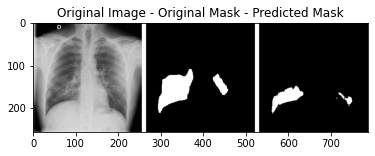

In [ ]:
#Predicting images
def get_pred_img(model, image, mask):
  #Original Image
  img_cpy = image.copy() 
  img_cpy = np.expand_dims(img_cpy, axis = 0)
  #Predicted Mask
  pred = model.predict(img_cpy)>0.5 
  pred = pred.astype(np.int32)
  pred = np.concatenate([pred, pred, pred], axis = -1) #converting single channel to 3 channels
  pred = np.squeeze(pred*255) #Converting pixels back to 0, 255
  #Original Mask
  mask = np.concatenate([mask, mask, mask], axis = -1) 
  #Seperator line between images
  sep_line = np.ones((H, 10, 3))*255   
  #Showing all images
  img = np.concatenate([image, sep_line, mask, sep_line, pred], axis = 1) 
  plt.title('Original Image - Original Mask - Predicted Mask')
  plt.imshow(img)
  plt.show()

  return pred

# save_model(model) #Saving model weights #GDRIVE connection
loaded_model = get_saved_model()
pred = get_pred_img(loaded_model, X[8], y[8])

# WORK PACKAGE 2: Task 2: Lesion Quantification of COVID-19 Infected region

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


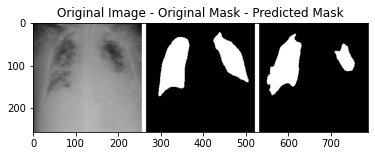

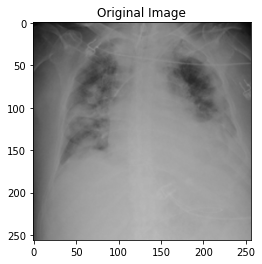

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


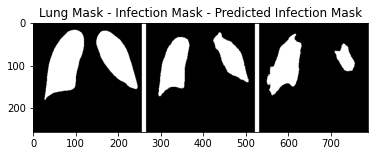

Lung mask 24.87%, Infection mask 16.55%, Lesion quantification for original 66.52%, Lesion quantification for V-net prediction 51.03%


In [ ]:
#Lesion Quantification 
def get_lesion_quant(orig_img, lung_msk, inf_msk, pred_msk):
  def get_prcnt(img):
    img = img.astype(np.uint8)
    #Numerical representation of white space in a black & white image i. e lung or infection mask 
    percent_inf = (np.count_nonzero(img) * 100)/ img.size 
    return percent_inf

  lung_prcnt = get_prcnt(lung_msk) #Lung mask
  inf_prcnt = get_prcnt(inf_msk) #Infection mask
  pred_prcnt = get_prcnt(pred_msk) #Predicted Infection mask

  lesion_quant = (inf_prcnt*100)/lung_prcnt  #Lesion Quantification: original infection mask
  lesion_quant_pred = (pred_prcnt*100)/lung_prcnt #Lesion Quantification: predicted infection mask

  #Showing all images
  lung_msk = lung_msk.reshape(1, 256, 256, 1)
  lung_msk = np.concatenate([lung_msk, lung_msk, lung_msk], axis = -1)
  lung_msk = lung_msk.reshape(256, 256, 3)

  inf_msk = inf_msk.reshape(1, 256, 256, 1)
  inf_msk = np.concatenate([inf_msk, inf_msk, inf_msk], axis = -1)A
  inf_msk = inf_msk.reshape(256, 256, 3)

  sep_line = np.ones((H, 10, 3))*255  
  plt.title('Original Image')
  plt.imshow(orig_img)
  plt.show()
  img = np.concatenate([lung_msk, sep_line, inf_msk, sep_line, pred_msk], axis = 1) 
  plt.title('Lung Mask - Infection Mask - Predicted Infection Mask')
  plt.imshow(img)
  plt.show()
  print('Lung mask {}%, Infection mask {}%, Lesion quantification for original {}%, Lesion quantification for V-net prediction {}%'.format(round(lung_prcnt, 2), round(inf_prcnt, 2), round(lesion_quant, 2), round(lesion_quant_pred, 2)))
  # return round(lesion_quant, 2)

#Run model for Lesion Quantification
img_idx = 2
img = img_train[img_idx]
img1 = img_train_lungmask[img_idx]
img2 = img_train_infmask[img_idx]
img3 = get_pred_img(loaded_model, X[img_idx], y[img_idx]) #loaded model is using saved model weights in google drive
get_lesion_quant(img, img1, img2, img3)

# WORK PACKAGE 3:Grad-Cam Model - Lesion Localization

In [ ]:
loaded_model.summary() #Note last convolutional layer name for the V-net model required for Grad-Cam model


Before Heatmap shape  (256, 256)


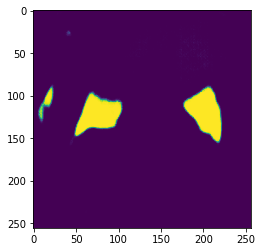

Heatmap, Hmgrid and Image Shapes:  (1, 256, 256, 3) (256, 256, 3) (1, 256, 256, 3)
Heatmap after resizing  (1, 256, 256, 3)


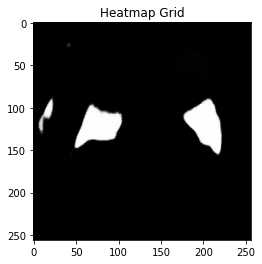

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


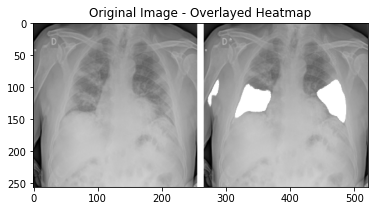

In [ ]:
#Grad-CAM model
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()


    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                     self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

#Getting visual mapping using predicted segments by V-net model using Grad-CAM model
def get_gradcam_image(image, model):  #def get_gradcam_image(image):
  INTENSITY = 0.005#0.05 # 0.5
  image = image.reshape(-1,256, 256, 3)
  i = np.argmax(pred[0])
  chosen_layer = 'conv2d_161'

  #Passing to Grad-Cam class
  icam = GradCAM(model, i, chosen_layer)  #Put layer name
  heatmap = icam.compute_heatmap(image)  #image will be X[4] # 1 channel image is created
  print('Before Heatmap shape ', heatmap.shape)
  plt.imshow(heatmap)
  plt.show()
  heatmap = heatmap.reshape(1, 256, 256, 1) #Turning image to grayscale
  heatmap = np.concatenate([heatmap, heatmap, heatmap], axis = -1)
  hm_grid = heatmap.reshape(256, 256, 3)
  print('Heatmap, Hmgrid and Image Shapes: ', heatmap.shape, hm_grid.shape, image.shape)
  new_image = heatmap * INTENSITY + image

  #Showing all images
  sep_line = np.ones((H, 10, 3))*255  
  plt.title('Heatmap Grid') 
  plt.imshow(hm_grid)
  plt.show()
  img = np.concatenate([image.reshape(256, 256, 3), sep_line, new_image.reshape(256, 256, 3)], axis = 1) 
  plt.title('Original Image - Overlayed Heatmap')
  plt.imshow(img)
  plt.show()

  return heatmap

heatmap = get_gradcam_image(X[7], loaded_model) #get_gradcam_image(X[8])

# WORK PACKAGE 4: LIME-XAI - Explainable AI

Mounted at /content/gdrive


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


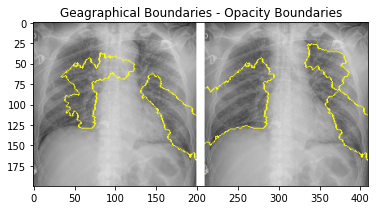

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

#LIME-XAI model
#Creating boundaries along activation regions identified by CNN model 
def get_lime_boundaries(X_train, model_geo, model_opacity, img_idx):
  def get_img_msk(model):
    explainer = lime_image.LimeImageExplainer(random_state=1)
    explanation = explainer.explain_instance(
            X_train[img_idx].astype('double'), 
            model.predict  #Compression-based CNN model
    )
    image, mask = explanation.get_image_and_mask(
            model.predict(
                  X_train[img_idx].reshape((1,200,200,3))
            ).argmax(axis=1)[0],
            positive_only=True, 
            hide_rest=False)
    
    return image, mask

  img_geo, mask_geo = get_img_msk(model_geo) #Get image, mask for geographical means
  img_opa, mask_opa = get_img_msk(model_opacity) #Get image, mask for opacity means

  #Showing all images
  sep_line = np.ones((200, 10, 3))*255  
  img = np.concatenate([mark_boundaries(img_geo, mask_geo), sep_line, mark_boundaries(img_opa, mask_opa).reshape(200,200,3)], axis = 1) 
  plt.title('Geagraphical Boundaries - Opacity Boundaries')
  plt.imshow(img)
  plt.show()

# Data
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv"
image_path = "/content/gdrive/My Drive/AIThesis/images"
severity_url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/annotations/covid-severity-scores.csv"
data_meta, data_image = get_data(url, image_path, severity_url)

#Get Geographical boundaries used for prediction
X_train, X_test, y_train, y_test, common_idxs, X = get_train_test(data_image) #Geo means
model_wp1_cnn_geo = model_wp1_cnn(X_train, X_test, y_train, y_test) #Get model to predict geo mean

#Get Opacity boundaries used for prediction
X_train, X_test, y_train, y_test, common_idxs, X = get_train_test(data_image, geo = False) #Opacity means
model_wp1_cnn_opacity = model_wp1_cnn(X_train, X_test, y_train, y_test) #Get model to predict opactiy mean

#Run LIME-XAI model to get lesion boundaries used to predict gragraphical and opacity mean
get_lime_boundaries(X_train, model_wp1_cnn_geo, model_wp1_cnn_opacity, img_idx = 7) 